# P5: DATA ENGINEERING - Building The Reporting Schema
 
## Notebook Description

In this notebook, an analytical and reporting system will be developed to inform future business decisions. As a first step, the following data visualizations will be created:

1. **Displaying the top 10 airports by departures**, also displaying the number of arrivals in a table format
2. **Displaying the top 10 flight routes**, with the lowest percentage of delays in a table format
3. **Displaying a comparison of 2019 and 2020**, in the form of a bar chart
   - Monthly comparison
   - Weekly day-by-day comparison
4. **Displaying day-by-day data**, in the form of a time series

The report will be structured into three sections: `TOP Report`, `Comparison`, and `Day-by-Day Reliability`.

By utilizing the previously predefined database views (N05_Data_Engineering_Building_Reporting_Schema), the need for additional data processing and handling is eliminated. Additionally, technical aspects such as row counts, joins, and filters are offloaded to the database, reducing the volume of data exchanged between the service and the database.

####
## Notebook Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Libraries import</p>

In [1]:
# # import psycopg2
# from psycopg2 import connect
# import pandas as pd
# # from sqlalchemy import create_engine
# import matplotlib.pyplot as plt
# import dash
# from dash import dash_table, dcc, html
# from dash.dependencies import Input, Output, State
# # import plotly.express as px
# # import threading
# # from dash import dcc
# # from dash import html
# import plotly.graph_objs as go

In [2]:
from psycopg2 import connect
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import dash
from dash import dash_table, dcc, html
from dash.dependencies import Input, Output, State

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Connecting to the database</p>

In [3]:
cnx = connect(user='postgres_user', password='coderslab', host='localhost', database='airlines')
cursor = cnx.cursor()

###
## Displaying The Top 10 Reliable Airports By Departure

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [4]:
sql_query_top_10_airports = """SELECT 
                                    al.display_airport_name AS Airport, 
                                    f.year AS Year, 
                                    ROUND(CAST(SUM(f.nas_delay) AS numeric) / CAST(COUNT(*) AS numeric), 2) AS Reliability, 
                                    DENSE_RANK() OVER (ORDER BY ROUND(CAST(SUM(f.nas_delay) AS numeric) / CAST(COUNT(*) AS numeric), 2) DESC) AS Rank 
                                FROM 
                                    flight AS f
                                LEFT JOIN 
                                    airport_list AS al ON f.origin_airport_id = al.origin_airport_id
                                GROUP BY 
                                    al.display_airport_name, 
                                    f.year
                                HAVING 
                                    COUNT(*) > 10000
                                ORDER BY 
                                    Reliability DESC
                                LIMIT 10
                                """

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the 'reporting.top_reliability_roads' view</p>

In [5]:
cursor.execute(sql_query_top_10_airports)
top_airports_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
top_airports_df = pd.DataFrame(top_airports_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Changing the number format in the 'reliability' column to a percentage format</p>

In [6]:
top_airports_df['reliability'] = top_airports_df['reliability'].apply(lambda x: '{:.2%}'.format(x / 100))

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Renaming the columns</p>

In [7]:
top_airports_df = top_airports_df.rename(columns={'airport': 'departure airport name'})

In [8]:
top_airports_df

,departure airport name,year,reliability,rank
0,Portland International Jetport,2019,5.82%,1
1,Palm Beach International,2019,5.49%,2
2,Northwest Arkansas Regional,2019,5.17%,3
3,Minneapolis-St Paul International,2019,5.09%,4
4,Newark Liberty International,2019,4.92%,5
5,John F. Kennedy International,2019,4.84%,6
6,Rochester Monroe County,2019,4.81%,7
7,Richmond International,2019,4.69%,8
8,LaGuardia,2019,4.64%,9
9,Cincinnati/Northern Kentucky International,2019,4.60%,10


###
## Displaying The Top 10 Most Reliable Routes

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [9]:
sql_query_top_10_routes = """SELECT 
                                origin_airport_name AS Origin, 
                                dest_airport_name AS Destination, 
                                year AS Year, 
                                reliability AS Reliability, 
                                nb AS Rank 
                            FROM reporting.top_reliability_roads 
                            ORDER BY nb 
                            LIMIT 10
                            """

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the 'reporting.top_reliability_roads' view</p>

In [10]:
cursor.execute(sql_query_top_10_routes)
top_routes_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
top_routes_df = pd.DataFrame(top_routes_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Changing the number format in the 'reliability' column to a percentage format</p>

In [11]:
top_routes_df['reliability'] = top_routes_df['reliability'].apply(lambda x: '{:.2%}'.format(x / 100))

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Renaming the columns</p>

In [12]:
top_routes_df = top_routes_df.rename(columns={'origin': 'origin airport', 'destination': 'destination airport'})

In [13]:
top_routes_df

,origin airport,destination airport,year,reliability,rank
0,Chicago O'Hare International,LaGuardia,2019,11.09%,1
1,LaGuardia,Chicago O'Hare International,2019,9.13%,2
2,Logan International,LaGuardia,2019,8.38%,3
3,Los Angeles International,San Francisco International,2019,8.00%,4
4,LaGuardia,Logan International,2019,5.66%,5
5,Los Angeles International,John F. Kennedy International,2019,5.09%,6
6,John F. Kennedy International,Los Angeles International,2019,4.24%,7
7,San Francisco International,Los Angeles International,2019,2.94%,8
8,McCarran International,Los Angeles International,2019,2.26%,9
9,Los Angeles International,McCarran International,2019,2.14%,10


###
## Displaying a Comparison Of 2019 And 2020

#### Month-to-Month

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [14]:
sql_query_mom = "SELECT * FROM reporting.month_to_month_comparision"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.month_to_month_comparision' view</p>

In [15]:
cursor.execute(sql_query_mom)
mom_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
mom_comparision_df = pd.DataFrame(mom_comparision_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Transforming the results into the format expected by a bar chart</p>

In [16]:
mom_comparision_df['reliability'] = mom_comparision_df['reliability'].astype(float)

In [17]:
mom_comparision_to_plot_df = mom_comparision_df.pivot(index='month', columns='year', values='reliability')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Drawing a bar chart</p>

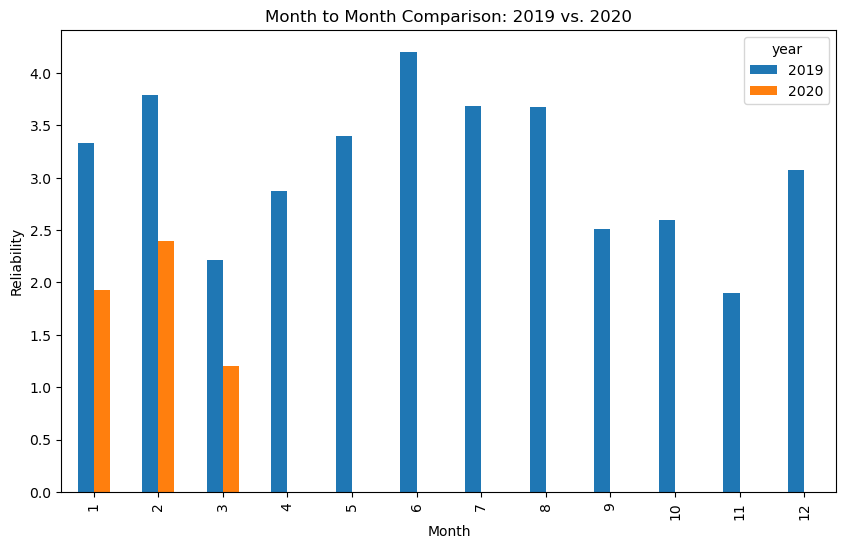

In [18]:
mom_comparision_fig = mom_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
mom_comparision_fig.set_xlabel('Month')
mom_comparision_fig.set_ylabel('Reliability')
mom_comparision_fig.set_title('Month to Month Comparison: 2019 vs. 2020')
plt.show()

In [19]:
# TUTAJ NOWE
# Creating a Plotly-compatible figure for the Month-to-Month comparison
mom_comparision_fig = {
    'data': [
        {'x': mom_comparision_to_plot_df.index, 'y': mom_comparision_to_plot_df[2019], 'type': 'bar', 'name': '2019'},
        {'x': mom_comparision_to_plot_df.index, 'y': mom_comparision_to_plot_df[2020], 'type': 'bar', 'name': '2020'},
    ],
    'layout': {
        'title': 'Month-to-Month Comparison: 2019 vs. 2020',
        'xaxis': {'title': 'Month'},
        'yaxis': {'title': 'Reliability'},
    }
}


###
#### Day-to-Day

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [20]:
sql_query_dod = "SELECT * FROM reporting.day_to_day_comparision"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.day_to_day_comparision' view</p>

In [21]:
cursor.execute(sql_query_dod)
dod_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
dod_comparision_df = pd.DataFrame(dod_comparision_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Transforming the results into the format expected by a bar chart</p>

In [22]:
dod_comparision_to_plot_df = dod_comparision_df.pivot(index='day_of_week', columns='year', values='flights_amount')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Drawing a bar chart</p>

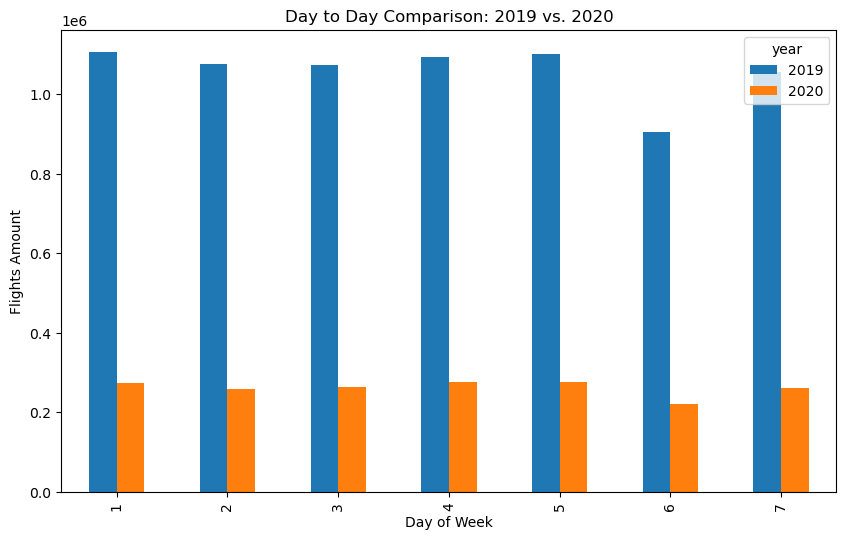

In [23]:
dod_comparision_fig = dod_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
dod_comparision_fig.set_xlabel('Day of Week')
dod_comparision_fig.set_ylabel('Flights Amount')
dod_comparision_fig.set_title('Day to Day Comparison: 2019 vs. 2020')
plt.show()

In [24]:
# TUTAJ NOWE
# Creating a Plotly-compatible figure for the Day-to-Day comparison
dod_comparision_fig = {
    'data': [
        {'x': dod_comparision_to_plot_df.index, 'y': dod_comparision_to_plot_df[2019], 'type': 'bar', 'name': '2019'},
        {'x': dod_comparision_to_plot_df.index, 'y': dod_comparision_to_plot_df[2020], 'type': 'bar', 'name': '2020'},
    ],
    'layout': {
        'title': 'Day-to-Day Comparison: 2019 vs. 2020',
        'xaxis': {'title': 'Day of Week'},
        'yaxis': {'title': 'Flights Amount'},
    }
}

###
## Displaying `day-by-day` Reliability Data As Time Series

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [25]:
sql_query_dbd_reliability_2019 = "SELECT * FROM reporting.day_by_day_reliability WHERE year = 2019"
sql_query_dbd_reliability_2020 = "SELECT * FROM reporting.day_by_day_reliability WHERE year = 2020"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.day_by_day_reliability' view</p>

In [26]:
# fetch data for 2019
cursor.execute(sql_query_dbd_reliability_2019)
dbd_reliability_data_2019 = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_2019 = pd.DataFrame(dbd_reliability_data_2019, columns=columns)

# fetch data for 2020
cursor.execute(sql_query_dbd_reliability_2020)
dbd_reliability_data_2020 = cursor.fetchall()
df_2020 = pd.DataFrame(dbd_reliability_data_2020, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Plotting a time series chart</p>

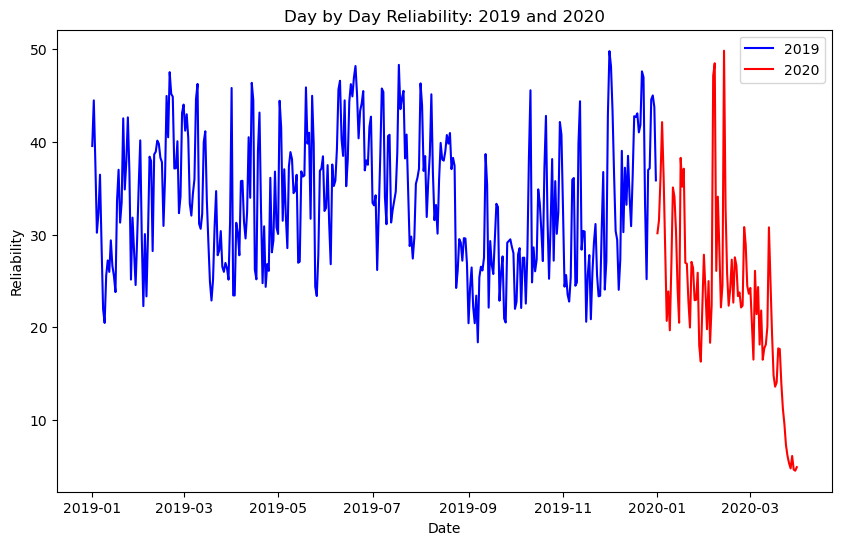

In [27]:
dbd_reliability_fig = plt.figure(figsize=(10, 6))
plt.plot(df_2019['date'], df_2019['reliability'], color='blue', label='2019')
plt.plot(df_2020['date'], df_2020['reliability'], color='red', label='2020')
plt.xlabel('Date')
plt.ylabel('Reliability')
plt.title('Day by Day Reliability: 2019 and 2020')
plt.legend()
plt.show()

In [28]:
# TUTAJ NOWE
# Saving the plot to a BytesIO object and converting to base64
img = BytesIO()
dbd_reliability_fig.savefig(img, format='png')
img.seek(0)
dbd_reliability_fig_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
img.close()

 # Konfigurowanie aplikacji
 Posiadamy już wszystkie niezbędne komponenty do stworzenia oraz uruchomienia aplikacji. Naszym zadaniem w tym miejscu będzie odpowiednie jej skonfigurowanie, aby obsługiwała więcej niż jedną stronę.

 Chcemy, aby możliwe było poruszanie się pomiędzy poniższymi stronami:
 - `TOP report` - strona domyślna,
 - `Comparision` - strona dostępna pod adresem: `comparision_reporting`,
 - `Day by day reporting` - strona dostępna pod adresem: `day_by_day_reporting`

Wskazówki:
 - `Wizualizacja danych > Dzień 4 > Callback context`,
 - `Wizualizacja danych > Dzień 4 > Aplikacja multipage`.
 - Używając komponentu [html.Button](https://community.plotly.com/t/button-with-link/11809), możesz łatwo stworzyć bardziej wizualne linki do poszczególnych stron.

###
## DASH Display

### Constructing Views and Layouts With Retrieved Data

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a Dash view for the 'Top 10 Most Reliable Routes' table</p>

In [29]:
top_routes_table = dash_table.DataTable(
    id='top-routes-table',
    columns=[{"name": i, "id": i} for i in top_routes_df.columns],
    data=top_routes_df.to_dict('records'),
)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Setting up the table's title</p>

In [30]:
top_routes_page_title = html.H3(
    "The Top 10 Most Reliable Routes in 2019 and 2020",
    style={"font-family": "verdana", "color": "#444444"}
)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a layout for the 'Top 10 Most Reliable Routes' table</p>

In [31]:
top_routes_layout = html.Div(children=[
    top_routes_page_title,
    top_routes_table
])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a Dash view for the 'month-to-month' comparison</p>

In [32]:
mom_comparision_component = dcc.Graph(
    id='mom-comparision-graph',
    figure=mom_comparision_fig
)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a Dash view for the 'day-to-day' comparison</p>

In [33]:
day_to_day_comparision_component = dcc.Graph(
    id='dod-comparision-graph',
    figure=dod_comparision_fig
)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating layouts and headlines for the 'month-to-month' and 'day-to-day' comparisons</p>

In [34]:
comparision_layout = html.Div(children=[
    html.H3("Month to Month Comparision"),
    mom_comparision_component,
    html.H3("Day to Day Comparision"),
    day_to_day_comparision_component
])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the layout and headline for the 'day-by-day' reliability time series</p>

In [35]:
day_by_day_layout = html.Div(children=[
    html.H3("Day by Day Reliability"),
    dbd_reliability_fig
])

###
### DASH Display Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the layout for the Dash displa</p>

In [36]:
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     dcc.Location(id='url', refresh=False),
#     html.Button("Go to Comparision", id="btn-comparision", n_clicks=0),
#     html.Button("Go to Day by Day Reporting", id="btn-day-by-day", n_clicks=0),
#     html.Div(id='page-content')
# ])

In [37]:
# Creating the Dash layout
app = dash.Dash(__name__)

# Layout for displaying the data and graphs
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    html.Button("Go to Comparision", id="btn-comparision", n_clicks=0),
    html.Button("Go to Day by Day Reporting", id="btn-day-by-day", n_clicks=0),
    html.Div(id='page-content')
])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Configuring the display's navigation</p>

In [38]:
# @app.callback(Output('url', 'pathname'),
#               [Input('btn-comparision', 'n_clicks'),
#                Input('btn-day-by-day', 'n_clicks')],
#               [State('url', 'pathname')])
# def update_url(btn_comparision_clicks, btn_day_by_day_clicks, current_path):
#     ctx = dash.callback_context
#     if not ctx.triggered:
#         return current_path
#     else:
#         button_id = ctx.triggered[0]["prop_id"].split(".")[0]
#         if button_id == "btn-comparision":
#             return "/comparision_reporting"
#         elif button_id == "btn-day-by-day":
#             return "/day_by_day_reporting"
#         else:
#             return current_path

In [39]:
# Updating the page content based on button clicks
@app.callback(Output('url', 'pathname'),
              [Input('btn-comparision', 'n_clicks'),
               Input('btn-day-by-day', 'n_clicks')],
              [State('url', 'pathname')])
def update_url(btn_comparision_clicks, btn_day_by_day_clicks, current_path):
    ctx = dash.callback_context
    if not ctx.triggered:
        return current_path
    else:
        button_id = ctx.triggered[0]["prop_id"].split(".")[0]
        if button_id == "btn-comparision":
            return "/comparision_reporting"
        elif button_id == "btn-day-by-day":
            return "/day_by_day_reporting"
        else:
            return current_path

In [40]:
# @app.callback(Output('page-content', 'children'),
#               [Input('url', 'pathname')])
# def display_page(pathname):
#     if pathname == '/':
#         return top_routes_layout
#     elif pathname == '/comparision_reporting':
#         return comparision_layout
#     elif pathname == '/day_by_day_reporting':
#         return day_by_day_layout
#     else:
#         return '404 Page not found'

In [41]:
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/':
        return html.Div([dash_table.DataTable(
            id='top-routes-table',
            columns=[{"name": i, "id": i} for i in top_routes_df.columns],
            data=top_routes_df.to_dict('records')
        )])
    elif pathname == '/comparision_reporting':
        return html.Div([dcc.Graph(figure=mom_comparision_fig),
                         dcc.Graph(figure=dod_comparision_fig)])
    elif pathname == '/day_by_day_reporting':
        return html.Div([html.H3("Day by Day Reliability"),
                         html.Img(src=f"data:image/png;base64,{dbd_reliability_fig_base64}")])
    else:
        return html.Div([html.H3("404: Page not found")])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Starting the Dash display</p>

In [42]:
if __name__ == '__main__':
    app.run_server(debug=False)